In [4]:
import glob
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import matplotlib
from collections import Counter
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
import shutil
import h5py

In [2]:
df = pd.read_csv("../BraTS20 Training Metadata.csv")
file_name = df['slice_path'].apply(lambda path: path.split("/")[-1])
target = df['target']

mapping = []

for f, t in zip(file_name, target):
    mapping.append((f, t))

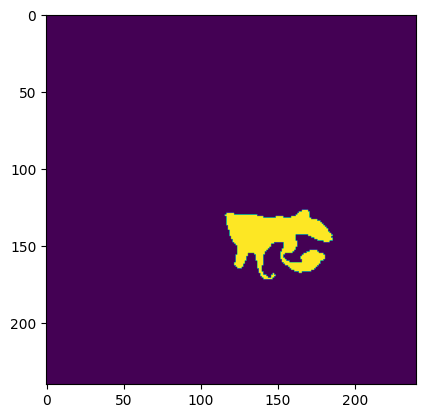

In [3]:
idx = np.random.randint(len(mapping))
image_file = os.path.join("../data", mapping[idx][0])

with h5py.File(image_file, "r") as file:
    image = np.array(file['image'])
    mask = np.array(file['mask'])

    layer0 = mask[:, :, 0]
    layer1 = mask[:, :, 1]
    layer2 = mask[:, :, 2]
    layer0[np.where(layer0 > 0)] = 50
    layer1[np.where(layer1 > 0)] = 100
    layer2[np.where(layer2 > 0)] = 200

    final_mask = np.zeros_like(layer0)

    for i in range(240):
        for j in range(240):
            if layer2[i][j] > 0:
                final_mask[i][j] = layer2[i][j]

    for i in range(240):
        for j in range(240):
            if layer1[i][j] > 0:
                final_mask[i][j] = layer1[i][j]
    
    for i in range(240):
        for j in range(240):
            if layer0[i][j] > 0:
                final_mask[i][j] = layer0[i][j] 

    plt.imshow(final_mask)
    plt.show()

In [6]:
idx = np.random.randint(len(mapping))
image_save_path = "../images"
mask_save_path = "../mask"

for idx, (image_name, label) in enumerate(mapping):
    image_file = os.path.join("../data", image_name)
    with h5py.File(image_file, "r") as file:
        image = np.array(file['image'])
        mask = np.array(file['mask'])
        # plt.figure(figsize=(16, 6))
        # plt.subplot(1, 4, 1)
        # plt.axis('off')
        # plt.imshow(image[:, :, 0], cmap="gray")

        # plt.subplot(1, 4, 2)
        # plt.axis('off')
        # plt.imshow(image[:, :, 1], cmap="gray")

        # plt.subplot(1, 4, 3)
        # plt.axis('off')
        # plt.imshow(image[:, :, 2], cmap="gray")

        # plt.subplot(1, 4, 4)
        # plt.axis('off')
        # plt.imshow(image[:, :, 3], cmap="gray")

        # plt.show()
        slice = image[:, :, 3]
        flatten_img = slice.flatten()

        no_zero = len(flatten_img[np.where(flatten_img > 0.0)])
        volume = no_zero / (slice.shape[0] * slice.shape[1])

        # print(label, volume)
        
        if volume >= 0.20:
            layer0 = mask[:, :, 0]
            layer1 = mask[:, :, 1]
            layer2 = mask[:, :, 2]
            layer0[np.where(layer0 > 0)] = 50
            layer1[np.where(layer1 > 0)] = 100
            layer2[np.where(layer2 > 0)] = 200

            final_mask = np.zeros_like(layer0)

            for i in range(240):
                for j in range(240):
                    if layer2[i][j] > 0:
                        final_mask[i][j] = layer2[i][j]
                    if layer1[i][j] > 0:
                        final_mask[i][j] = layer1[i][j]
                    if layer0[i][j] > 0:
                        final_mask[i][j] = layer0[i][j]


            saving_path = os.path.join(mask_save_path, f"{label}\{idx}.png")
            cropped_size = 25
            cropped_img = final_mask[cropped_size:-cropped_size, cropped_size:-cropped_size]
            matplotlib.image.imsave(saving_path, cropped_img)

            # break
        
        if idx % 100 == 0:
            print(f"{idx} done....")

(240, 240, 4)


NameError: name 'mapping' is not defined

In [2]:
mask_path = glob.glob("../images/mask/1/*")
saving_path = "../images/filtered-1"
mask_images = []

In [3]:
for path in tqdm(mask_path):
    mask = cv2.imread(path)
    name = path.split("\\")[-1]
    mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
    bg = Counter(mask.flatten())[33]
    percentage = bg / (190*190)
    if percentage < 0.995:
        # shutil.copy(path, os.path.join(saving_path, name))
        mask_images.append(name.split(".")[0])

  0%|          | 0/19305 [00:00<?, ?it/s]

In [7]:
label = [1 for _ in range(len(mask_images))]

In [15]:
mask_path_0 = [name.split("\\")[-1].split(".")[0] for name in glob.glob("../images/mask/0/*")]
label.extend([0 for _ in range(len(mask_path_0))])

In [18]:
all_masks = mask_images + mask_path_0

In [22]:
X_train, X_test, y_train, y_test = train_test_split(all_masks, label, test_size=0.20, random_state=42, stratify=label, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42, stratify=y_train, shuffle=True)

In [24]:
len(all_masks)

23574

In [23]:
len(X_train), len(X_val), len(X_test)

(16501, 2358, 4715)

In [29]:
val_path = "../splitted/val"
for (img_name, label) in zip(X_val, y_val):
    shutil.copy(f"../images/{label}/{img_name}_0.png", os.path.join(f"{val_path}/{label}", f"{img_name}_0.png"))
    shutil.copy(f"../images/{label}/{img_name}_1.png", os.path.join(f"{val_path}/{label}", f"{img_name}_1.png"))
    shutil.copy(f"../images/{label}/{img_name}_2.png", os.path.join(f"{val_path}/{label}", f"{img_name}_2.png"))
    shutil.copy(f"../images/{label}/{img_name}_3.png", os.path.join(f"{val_path}/{label}", f"{img_name}_3.png"))

In [ ]:
test_path = "../splitted/test"
for (img_name, label) in zip(X_test, y_test):
    shutil.copy(f"../images/{label}/{img_name}_0.png", os.path.join(f"{test_path}/{label}", f"{img_name}_0.png"))
    shutil.copy(f"../images/{label}/{img_name}_1.png", os.path.join(f"{test_path}/{label}", f"{img_name}_1.png"))
    shutil.copy(f"../images/{label}/{img_name}_2.png", os.path.join(f"{test_path}/{label}", f"{img_name}_2.png"))
    shutil.copy(f"../images/{label}/{img_name}_3.png", os.path.join(f"{test_path}/{label}", f"{img_name}_3.png"))

In [ ]:
train_path = "../splitted/train"
for (img_name, label) in zip(X_train, y_train):
    shutil.copy(f"../images/{label}/{img_name}_0.png", os.path.join(f"{train_path}/{label}", f"{img_name}_0.png"))
    shutil.copy(f"../images/{label}/{img_name}_1.png", os.path.join(f"{train_path}/{label}", f"{img_name}_1.png"))
    shutil.copy(f"../images/{label}/{img_name}_2.png", os.path.join(f"{train_path}/{label}", f"{img_name}_2.png"))
    shutil.copy(f"../images/{label}/{img_name}_3.png", os.path.join(f"{train_path}/{label}", f"{img_name}_3.png"))

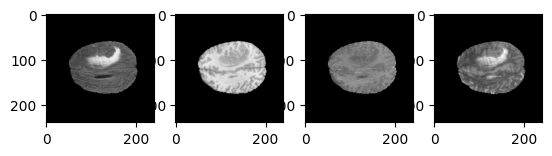

In [18]:
image_file = "../data/volume_1_slice_100.h5"

with h5py.File(image_file, "r") as file:
    image = np.array(file['image'])
    mask = np.array(file['mask'])
    
    _, axes = plt.subplots(1, 4)
    for idx, ax in enumerate(axes):
        ax.imshow(image[:, : , idx], cmap='gray')
